# Classify sarcasm dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [ ]:
# get sarcasm dataset
!git clone "https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection"

Cloning into 'News-Headlines-Dataset-For-Sarcasm-Detection'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 75 (delta 6), reused 0 (delta 0), pack-reused 62
Unpacking objects: 100% (75/75), 3.65 MiB | 4.86 MiB/s, done.


In [ ]:
# Get data from json
sarcasm_json = "/content/News-Headlines-Dataset-For-Sarcasm-Detection/Sarcasm_Headlines_Dataset.json"
def parseJson(fname):
    for line in open(fname, 'r'):
        yield eval(line)

sarcasm = list(parseJson(sarcasm_json))

In [ ]:
# Get data from json
sentences = []
labels = []
for data in sarcasm:
  label = data["is_sarcastic"]
  headline = data["headline"]
  sentences.append(headline)
  labels.append(label)

print("Check data examples:\n")
print(sentences[:3], labels[:3], "\n")

split_size = int(0.8*len(sentences))
train_data, test_data = sentences[:split_size], sentences[split_size:]
train_labels, test_labels = np.asarray(labels[:split_size], dtype=np.float), np.asarray(labels[split_size:], dtype=np.float)

# Hyperparams setup
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
pad_type = 'post' # where to put it?
oov_tok = "<OOV>"

# Tokenize dataset
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_data) # adapt tokenizer to dataset
word_index = tokenizer.word_index # get vocabulary

sequences = tokenizer.texts_to_sequences(train_data) # transform string data to ints
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
test_seqeunces = tokenizer.texts_to_sequences(test_data)
test_padded = pad_sequences(test_seqeunces, maxlen=max_length)

print("Check preprocessed tokens:\n")
print(padded[:3])


Check data examples:

['thirtysomething scientists unveil doomsday clock of hair loss', 'dem rep. totally nails why congress is falling short on gender, racial equality', 'eat your veggies: 9 deliciously different recipes'] [1, 0, 0] 



<ipython-input-27-aeeead62fa10>:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels, test_labels = np.asarray(labels[:split_size], dtype=np.float), np.asarray(labels[split_size:], dtype=np.float)


Check preprocessed tokens:

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     1  312 3527 6383 2299    3  628 1041]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_7 (Conv1D)           (None, 118, 16)           784       
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_14 (Dense)            (None, 6)                 102       
                                                                 
 dense_15 (Dense)            (None, 1)                 7         
                                                                 
Total params: 160,893
Trainable params: 160,893
Non-trainable params: 0
________________________________________________

<Axes: >

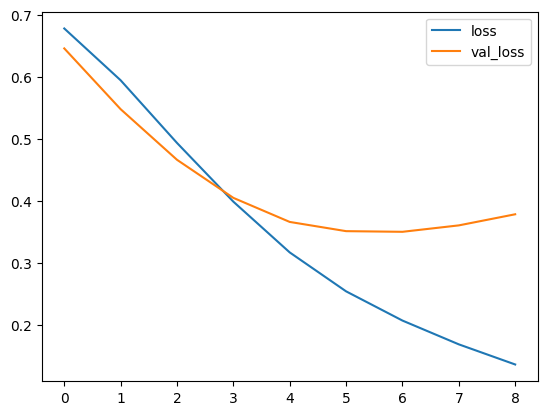

In [ ]:
# CNN modeling
model_conv = tf.keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  layers.Conv1D(16,3,activation="relu"),
  layers.GlobalMaxPool1D(),
  #layers.Dropout(0.2),
  #layers.Flatten(), # if we use maxpool1d we need flatten, if globalmaxpool1d we dont
  layers.Dense(6, activation="relu"),
  layers.Dense(1, activation="sigmoid")
])
model_conv.summary()

model_conv.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

num_epochs = 20
ES = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)
LR = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/num_epochs))

history = model_conv.fit(padded, train_labels, epochs=num_epochs, validation_data=(test_padded, test_labels), callbacks=[LR, ES])
pd.DataFrame(history.history)[["loss", "val_loss"]].plot()

In [ ]:
from sklearn.metrics import accuracy_score

model_conv_preds = model_conv.predict(test_padded)
print(model_conv_preds.shape, test_labels.shape)
model_conv_prediction = tf.round(tf.squeeze(model_conv_preds))
model_score = accuracy_score(test_labels, model_conv_prediction)
print(f"Model accuracy on valid set: {model_score}")

179/179 [==============================] - 0s 2ms/step
(5724, 1) (5724,)
Model accuracy on valid set: 0.846785464709993


In [ ]:
# Check out some samples
df = pd.DataFrame({
    "test_samples":test_data,
    "test_labels":test_labels,
    "predictions": model_conv_prediction,
    "prediction_probabilites": tf.squeeze(model_conv_preds)*100
})
df.head(10)

,test_samples,test_labels,predictions,prediction_probabilites
0,burger king's royal taster found dead,1.0,1.0,0.980963
1,vessel for male sexual gratification very sad ...,1.0,1.0,0.818211
2,starbucks unveils $7 wake-up slap,1.0,1.0,0.847439
3,obama unsure how to turn huge support among wo...,1.0,1.0,0.678954
4,"clinton goes back in time, teams up with golde...",1.0,1.0,0.875184
5,aid workers face an underreported sexual viole...,0.0,0.0,0.004483
6,nation would rather think about 9/11 than anyt...,1.0,1.0,0.992578
7,praying mantis hesitantly agrees to try girlfr...,1.0,1.0,0.684447
8,"isis and boko haram are teaming up for terror,...",0.0,0.0,0.001093
9,gun used to kill man in city,1.0,1.0,0.699086


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5724 entries, 0 to 5723
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   test_samples             5724 non-null   object 
 1   test_labels              5724 non-null   float64
 2   predictions              5724 non-null   float32
 3   prediction_probabilites  5724 non-null   float32
dtypes: float32(2), float64(1), object(1)
memory usage: 134.3+ KB


In [ ]:
# Lets find most wrong predictions:
# - we have them in the format that sigmoid provided
# - so we need to take the closest ones to 0.5, because that is the most ambiguous
df_most_wrongs = df[(df["prediction_probabilites"]>=0.4) & (df["prediction_probabilites"]<0.6) & (df["test_labels"]!=df["predictions"])]
df_most_wrongs

,test_samples,test_labels,predictions,prediction_probabilites
64,cambodian paper takes parting shot at 'dictato...,0.0,1.0,0.540001
176,obama administration approves plan to make pri...,0.0,1.0,0.587035
194,beautiful birth marred by hideous afterbirth,1.0,0.0,0.496050
208,vanessa williams reveals plans for new album,0.0,1.0,0.524093
210,paul ryan refuses to promise obamacare 'replac...,0.0,1.0,0.523266
...,...,...,...,...
5626,u.s. dignity reserves nearly depleted,1.0,0.0,0.404249
5668,safeguarding america's health system from sabo...,0.0,1.0,0.580422
5673,"would bernie sanders supporters take $200,000 ...",0.0,1.0,0.578732
5702,michael douglas denies masturbating in front o...,0.0,1.0,0.552695
